In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

#transfer to celsius
def fahr_to_celsius(temp_fahr):
    temp_celsius = (temp_fahr - 32)*5/9
    return temp_celsius

#https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094728/detail
weather_2018 = pd.read_csv("large/2684160.csv")


#remove the invaliad attribute
actual_data = weather_2018.drop(["STATION","NAME","LATITUDE","LONGITUDE","ELEVATION","AWND_ATTRIBUTES","PGTM",
"PGTM_ATTRIBUTES","PRCP_ATTRIBUTES","SNOW_ATTRIBUTES","SNWD_ATTRIBUTES","TAVG_ATTRIBUTES","TMAX_ATTRIBUTES",
"TMIN_ATTRIBUTES","TSUN","TSUN_ATTRIBUTES","WDF2","WDF2_ATTRIBUTES","WDF5","WDF5_ATTRIBUTES","WSF2","WSF2_ATTRIBUTES",
"WSF5","WSF5_ATTRIBUTES","WT01_ATTRIBUTES","WT02_ATTRIBUTES","WT03_ATTRIBUTES","WT04","WT04_ATTRIBUTES",
"WT06_ATTRIBUTES","WT08_ATTRIBUTES"],axis='columns')

#calculcate the average value and reject the weather type
a = actual_data["TMAX"]
actual_data["TMAX"]=fahr_to_celsius(a)
b = actual_data["TMIN"]
actual_data["TMIN"]= fahr_to_celsius(b)
actual_data["TAVG"] = (actual_data["TMAX"]+actual_data["TMIN"])/2
c = actual_data[["WT01","WT02","WT03","WT06","WT08"]]
actual_data["weather_type"] = c.sum(axis=1)
actual_data=actual_data.drop(["WT01","WT02","WT03","WT06","WT08","TMAX","TMIN"],axis="columns")
actual_data["weather_type"]=np.where(actual_data["weather_type"]>0,'Y','N')
actual_data
# save the data as the feather
actual_data.to_feather("new_2018_weather.feather")

yellow_01 = pd.read_csv("large/yellow_tripdata_2018-01.csv")
yellow_07 = pd.read_csv("large/yellow_tripdata_2018-07.csv")
yellow_08 = pd.read_csv("large/yellow_tripdata_2018-08.csv")
yellow_09 = pd.read_csv("large/yellow_tripdata_2018-09.csv")
yellow_10 = pd.read_csv("large/yellow_tripdata_2018-10.csv")
combined_data = yellow_08.append(yellow_09).append(yellow_10)
combined_data.reset_index().to_feather("2018_combined_data.feather")


In [118]:
remove_data = combined_data.drop(["VendorID","RatecodeID","store_and_fwd_flag","extra","mta_tax",
                    "tolls_amount","improvement_surcharge"],axis='columns')
remove_data["tpep_pickup_datetime"] = pd.to_datetime(remove_data["tpep_pickup_datetime"])
remove_data["tpep_dropoff_datetime"] = pd.to_datetime(remove_data["tpep_dropoff_datetime"])
remove_data["date"] = remove_data["tpep_pickup_datetime"].dt.normalize()
remove_data["period"]=(remove_data["tpep_dropoff_datetime"]-remove_data["tpep_pickup_datetime"])
remove_data["period"]=remove_data["period"]/np.timedelta64(1,'m')
remove_data["time"]=remove_data["tpep_pickup_datetime"].dt.hour
remove_data
weather

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,weather_type
0,1514764800000000000,7.83,0.00,0.0,0.0,-10.555556,N
1,1514851200000000000,8.05,0.00,0.0,0.0,-6.944444,N
2,1514937600000000000,3.13,0.00,0.0,0.0,-5.000000,N
3,1515024000000000000,12.53,0.76,9.8,1.2,-4.444444,Y
4,1515110400000000000,12.97,0.00,0.0,7.1,-10.000000,N
...,...,...,...,...,...,...,...
360,1545868800000000000,NaN,0.00,0.0,0.0,4.722222,N
361,1545955200000000000,NaN,1.15,0.0,0.0,10.833333,Y
362,1546041600000000000,NaN,0.00,0.0,0.0,8.888889,N
363,1546128000000000000,NaN,0.00,0.0,0.0,2.500000,N


In [74]:
#Remove noisy data
cleaned_combine = remove_data[remove_data['passenger_count'].gt(0)&(remove_data['passenger_count'].lt(7))]
cleaned_combine = cleaned_combine[cleaned_combine['trip_distance'].ne(float(0))&(cleaned_combine["trip_distance"].le(float(200)))]
cleaned_combine = cleaned_combine[cleaned_combine['payment_type'].eq(int(1))]
cleaned_combine = cleaned_combine[cleaned_combine['fare_amount'].ge(2.5)&(cleaned_combine['fare_amount'].le(600))]
cleaned_combine = cleaned_combine[cleaned_combine['total_amount'].ge(2.5)&(cleaned_combine['total_amount'].le(800))]
cleaned_combine = cleaned_combine[((cleaned_combine['tpep_pickup_datetime'] < "2018-10-31 23:59:59")&(cleaned_combine['tpep_pickup_datetime'] > "2018-08-01 00:00:00"))]
cleaned_combine = cleaned_combine[((cleaned_combine['tpep_dropoff_datetime'] < "2018-10-31 23:59:59")&(cleaned_combine['tpep_dropoff_datetime'] > "2018-08-01 00:00:00"))]
cleaned_combine = cleaned_combine[cleaned_combine['period'].gt(1)&(cleaned_combine['period'].le(300))]
cleaned_combine.reset_index().to_feather("2018_cleaned_combine.feather")
cleaned_combine

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,date,period,time
0,2018-08-01 00:44:35,2018-08-01 01:03:22,1,5.60,238,79,1,19.0,4.00,24.30,2018-08-01,18.783333,0
2,2018-08-01 00:13:25,2018-08-01 00:24:40,1,2.90,138,7,1,11.5,2.55,15.35,2018-08-01,11.250000,0
3,2018-08-01 00:10:37,2018-08-01 00:49:10,1,8.40,231,7,1,30.0,7.80,39.10,2018-08-01,38.550000,0
4,2018-08-01 00:02:18,2018-08-01 00:07:32,2,0.70,79,148,1,5.5,0.00,6.80,2018-08-01,5.233333,0
5,2018-08-01 00:22:51,2018-08-01 00:55:23,2,6.70,114,7,1,25.5,4.02,30.82,2018-08-01,32.533333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8821093,2018-10-31 23:29:14,2018-10-31 23:33:09,1,0.65,107,107,1,5.0,2.00,8.30,2018-10-31,3.916667,23
8821097,2018-10-31 23:07:25,2018-10-31 23:17:20,1,2.05,48,90,1,9.5,1.08,11.88,2018-10-31,9.916667,23
8821098,2018-10-31 23:19:18,2018-10-31 23:47:42,1,13.58,90,241,1,39.0,8.06,48.36,2018-10-31,28.400000,23
8821099,2018-10-31 23:04:18,2018-10-31 23:23:20,1,2.97,140,230,1,14.5,2.00,17.80,2018-10-31,19.033333,23


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,date,period,time
0,2018-08-01 00:44:35,2018-08-01 01:03:22,1,5.60,238,79,1,19.0,4.00,24.30,2018-08-01,18.783333,0
2,2018-08-01 00:13:25,2018-08-01 00:24:40,1,2.90,138,7,1,11.5,2.55,15.35,2018-08-01,11.250000,0
3,2018-08-01 00:10:37,2018-08-01 00:49:10,1,8.40,231,7,1,30.0,7.80,39.10,2018-08-01,38.550000,0
4,2018-08-01 00:02:18,2018-08-01 00:07:32,2,0.70,79,148,1,5.5,0.00,6.80,2018-08-01,5.233333,0
5,2018-08-01 00:22:51,2018-08-01 00:55:23,2,6.70,114,7,1,25.5,4.02,30.82,2018-08-01,32.533333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8821093,2018-10-31 23:29:14,2018-10-31 23:33:09,1,0.65,107,107,1,5.0,2.00,8.30,2018-10-31,3.916667,23
8821097,2018-10-31 23:07:25,2018-10-31 23:17:20,1,2.05,48,90,1,9.5,1.08,11.88,2018-10-31,9.916667,23
8821098,2018-10-31 23:19:18,2018-10-31 23:47:42,1,13.58,90,241,1,39.0,8.06,48.36,2018-10-31,28.400000,23
8821099,2018-10-31 23:04:18,2018-10-31 23:23:20,1,2.97,140,230,1,14.5,2.00,17.80,2018-10-31,19.033333,23


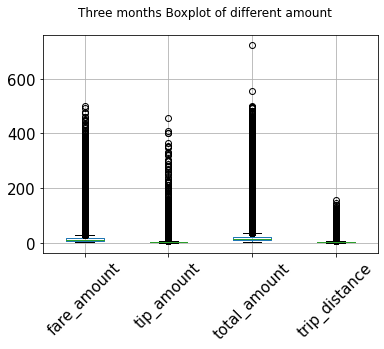

In [75]:
amount = ['fare_amount','tip_amount','total_amount','trip_distance']
amount_boxplot=cleaned_combine.boxplot(column=amount,rot=45, fontsize=15)
fig = amount_boxplot.get_figure()
fig.suptitle("Three months Boxplot of different amount")
fig.show()
fig.savefig("Original plot of three months for different amount.png")
Q1 = cleaned_combine[amount].quantile(0.25)
Q3 = cleaned_combine[amount].quantile(0.75)
IQR = Q3-Q1
cleaned = cleaned_combine[((cleaned_combine[amount].ge(Q1-3*IQR))&(cleaned_combine[amount].le(Q3+3*IQR))).any(axis=1)]
cleaned

In [123]:
#cleaned = cleaned_combine[((cleaned_combine[amount].ge(Q1-3*IQR))&(cleaned_combine[amount].le(Q3+3*IQR)))]
#new_boxplot=cleaned.boxplot(column=amount,rot=45, fontsize=15)
#fig = new_boxplot.get_figure()
#fig.suptitle("After Boxplot of different amount for 3 months")
#fig.show()
#fig.savefig("After plot of different amount for 3 months.png")

In [124]:
cleaned.reset_index().to_feather("2018_three_months_combine.feather")


In [125]:
#extra data set
weather = pd.read_feather("new_2018_weather.feather")
new = pd.read_feather("2018_three_months_combine.feather")
from datetime import datetime
weather["DATE"]=pd.to_datetime(weather["DATE"]).astype(np.int64)
new["date"]=pd.to_datetime(new["date"]).astype(np.int64)
new = new.drop(["payment_type"],axis = 'columns')
new_combine=pd.merge(new,weather,left_on="date", right_on="DATE")
new_combine

,index,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,date,period,time,DATE,AWND,PRCP,SNOW,SNWD,TAVG,weather_type
0,0,2018-08-01 00:44:35,2018-08-01 01:03:22,1,5.60,238,79,19.0,4.00,24.30,1533081600000000000,18.783333,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y
1,2,2018-08-01 00:13:25,2018-08-01 00:24:40,1,2.90,138,7,11.5,2.55,15.35,1533081600000000000,11.250000,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y
2,3,2018-08-01 00:10:37,2018-08-01 00:49:10,1,8.40,231,7,30.0,7.80,39.10,1533081600000000000,38.550000,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y
3,4,2018-08-01 00:02:18,2018-08-01 00:07:32,2,0.70,79,148,5.5,0.00,6.80,1533081600000000000,5.233333,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y
4,5,2018-08-01 00:22:51,2018-08-01 00:55:23,2,6.70,114,7,25.5,4.02,30.82,1533081600000000000,32.533333,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16359664,8821093,2018-10-31 23:29:14,2018-10-31 23:33:09,1,0.65,107,107,5.0,2.00,8.30,1540944000000000000,3.916667,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N
16359665,8821097,2018-10-31 23:07:25,2018-10-31 23:17:20,1,2.05,48,90,9.5,1.08,11.88,1540944000000000000,9.916667,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N
16359666,8821098,2018-10-31 23:19:18,2018-10-31 23:47:42,1,13.58,90,241,39.0,8.06,48.36,1540944000000000000,28.400000,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N
16359667,8821099,2018-10-31 23:04:18,2018-10-31 23:23:20,1,2.97,140,230,14.5,2.00,17.80,1540944000000000000,19.033333,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N


In [126]:
new_combine["zero_tip"]=np.where(new_combine["tip_amount"]>0,1,0)
new_combine.to_feather("2018_three_months_final_feather")


In [127]:
sample=new_combine.sample(frac=0.01,replace=True,random_state=30034)
sample = sample.sort_values(by=["tpep_pickup_datetime"]).reset_index(drop=True)
sample

,index,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,...,period,time,DATE,AWND,PRCP,SNOW,SNWD,TAVG,weather_type,zero_tip
0,28,2018-08-01 00:01:41,2018-08-01 00:06:33,3,0.80,45,231,5.5,1.00,7.80,...,4.866667,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y,1
1,225,2018-08-01 00:01:52,2018-08-01 00:09:27,1,1.35,234,234,7.0,1.66,9.96,...,7.583333,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y,1
2,1187,2018-08-01 00:02:12,2018-08-01 00:06:17,6,1.36,48,143,6.0,1.00,8.30,...,4.083333,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y,1
3,5912,2018-08-01 00:03:36,2018-08-01 00:38:33,1,14.06,132,40,40.5,6.27,48.07,...,34.950000,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y,1
4,4099,2018-08-01 00:03:57,2018-08-01 00:11:59,1,1.50,125,13,8.0,1.86,11.16,...,8.033333,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163592,8819726,2018-10-31 23:45:32,2018-10-31 23:53:38,1,1.15,230,163,7.0,2.08,10.38,...,8.100000,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N,1
163593,8813376,2018-10-31 23:50:03,2018-10-31 23:55:46,1,0.80,170,137,6.0,0.00,7.30,...,5.716667,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N,0
163594,8810202,2018-10-31 23:50:52,2018-10-31 23:55:00,1,0.82,263,263,5.0,1.26,7.56,...,4.133333,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N,1
163595,8817995,2018-10-31 23:52:24,2018-10-31 23:55:38,5,0.44,148,4,4.0,0.00,5.30,...,3.233333,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N,0


In [81]:
sample.to_csv("2018_sample.csv")
sample.to_feather("2018_sample.feather")


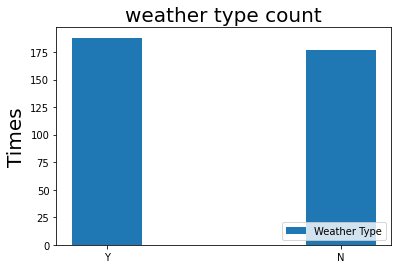

In [86]:
import matplotlib.pyplot as plt
sample_data=pd.read_feather("2018_sample.feather")
weather_count = weather["weather_type"].value_counts()
plt.figure(figsize=(6,4))
plt.bar(weather_count.index, weather_count,0.3,label="Weather Type")
plt.ylabel("Times",fontsize = 20)
plt.title("weather type count",fontsize =20)
plt.xticks(weather_count.index)
plt.legend(loc=4)

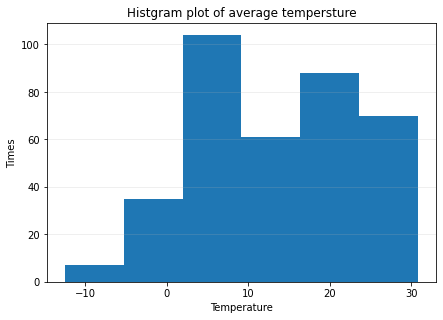

In [94]:
x = weather["TAVG"]
fig = plt.figure(figsize=(9,6))
histgram = fig.add_axes([0.6,0.6,0.6,0.6])
h=histgram.hist(x,bins=6)
plt.title('Histgram plot of average tempersture')
plt.xlabel('Temperature')
plt.ylabel('Times')
plt.grid(axis='y', alpha=0.25)
plt.show()

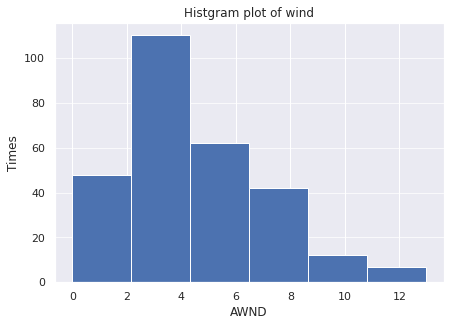

In [121]:
x = weather["AWND"]
fig = plt.figure(figsize=(9,6))
histgram = fig.add_axes([0.6,0.6,0.6,0.6])
h=histgram.hist(x,bins=6)
plt.title('Histgram plot of wind')
plt.xlabel('AWND')
plt.ylabel('Times')
plt.grid(axis='y', alpha=0.75)
plt.show()

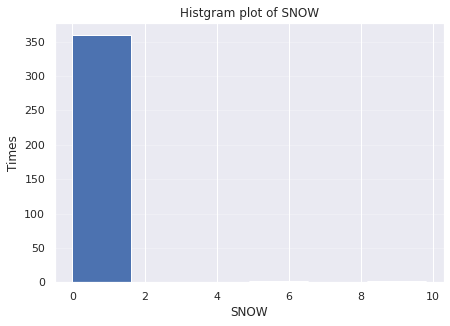

In [120]:
x = weather["SNOW"]
fig = plt.figure(figsize=(9,6))
histgram = fig.add_axes([0.6,0.6,0.6,0.6])
h=histgram.hist(x,bins=6)
plt.title('Histgram plot of SNOW')
plt.xlabel('SNOW')
plt.ylabel('Times')
plt.grid(axis='y', alpha=0.25)
plt.show()

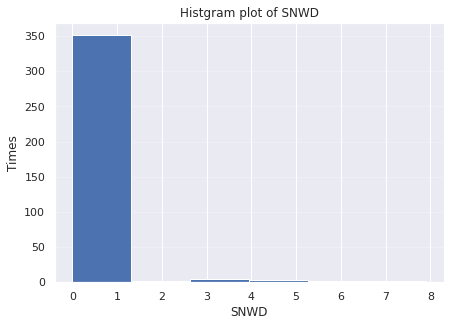

In [119]:
x = weather["SNWD"]
fig = plt.figure(figsize=(9,6))
histgram = fig.add_axes([0.6,0.6,0.6,0.6])
h=histgram.hist(x,bins=6)
plt.title('Histgram plot of SNWD')
plt.xlabel('SNWD')
plt.ylabel('Times')
plt.grid(axis='y', alpha=0.25)
plt.show()

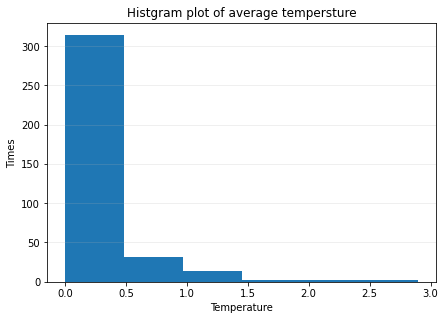

In [98]:
x = weather["PRCP"]
fig = plt.figure(figsize=(9,6))
histgram = fig.add_axes([0.6,0.6,0.6,0.6])
h=histgram.hist(x,bins=6)
plt.title('Histgram plot of PRCP')
plt.xlabel('PRCP')
plt.ylabel('Times')
plt.grid(axis='y', alpha=0.25)
plt.show()

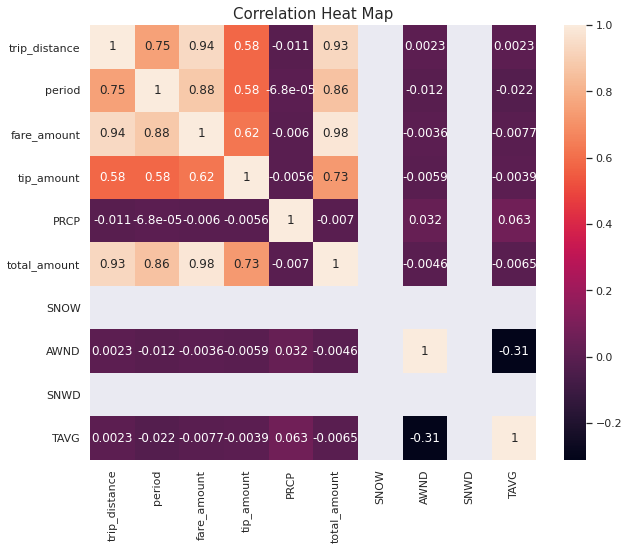

In [117]:
plt.figure(figsize=(10, 8))
col = ["trip_distance", "period", "fare_amount", "tip_amount", "PRCP",
       "total_amount", "SNOW", "AWND", "SNWD","TAVG"]
w_corrMatrix = sample_data[col].corr()
sns.heatmap((w_corrMatrix),annot=True)
plt.title("Correlation Heat Map",fontsize=15)
  
#sns.heatmap(sample_data.corr())
#col = ["trip_distance", "period", "fare_amount", "tip_amount", 
 #"PRCP", "total_amount", "SNOW", "AWND", "SNWD","TAVG"]
#sample_data[col].corr()
#sns.heatmap(sample_data[col].corr())
plt.show()


#heatmap = sns.heatmap(dataframe.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
#heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [122]:
sample_data

,index,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,...,period,time,DATE,AWND,PRCP,SNOW,SNWD,TAVG,weather_type,zero_tip
0,28,2018-08-01 00:01:41,2018-08-01 00:06:33,3,0.80,45,231,5.5,1.00,7.80,...,4.866667,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y,1
1,225,2018-08-01 00:01:52,2018-08-01 00:09:27,1,1.35,234,234,7.0,1.66,9.96,...,7.583333,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y,1
2,1187,2018-08-01 00:02:12,2018-08-01 00:06:17,6,1.36,48,143,6.0,1.00,8.30,...,4.083333,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y,1
3,5912,2018-08-01 00:03:36,2018-08-01 00:38:33,1,14.06,132,40,40.5,6.27,48.07,...,34.950000,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y,1
4,4099,2018-08-01 00:03:57,2018-08-01 00:11:59,1,1.50,125,13,8.0,1.86,11.16,...,8.033333,0,1533081600000000000,2.46,0.1,0.0,0.0,26.111111,Y,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163592,8819726,2018-10-31 23:45:32,2018-10-31 23:53:38,1,1.15,230,163,7.0,2.08,10.38,...,8.100000,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N,1
163593,8813376,2018-10-31 23:50:03,2018-10-31 23:55:46,1,0.80,170,137,6.0,0.00,7.30,...,5.716667,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N,0
163594,8810202,2018-10-31 23:50:52,2018-10-31 23:55:00,1,0.82,263,263,5.0,1.26,7.56,...,4.133333,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N,1
163595,8817995,2018-10-31 23:52:24,2018-10-31 23:55:38,5,0.44,148,4,4.0,0.00,5.30,...,3.233333,23,1540944000000000000,NaN,0.0,0.0,0.0,12.222222,N,0


In [154]:
# total amount(y), tip_amount,trip_distance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
model = LinearRegression()
value=list(sample_data["tip_amount"])
values=list(sample_data["trip_distance"])
y_value = pd.DataFrame([list(sample_data["total_amount"])]).T
list1=pd.DataFrame([value,values]).T
X_train, X_test, y_train, y_test = train_test_split(
   list1,y_value , test_size=0.33, random_state=42)
model.fit(X_train,y_train)
yellow_2019_11 = pd.read_csv("large/yellow_tripdata_2019-11.csv")

test_value=list(yellow_2019_11["tip_amount"])
test_values=list(yellow_2019_11["trip_distance"])
list2=pd.DataFrame([test_value,test_values]).T
new_test=model.predict(list2)
model.score(list2,new_test)


1.0